# Equivariant Quantum Circuits for Combinatorial Optimization Problems

## Setup

In [1]:
import random

# General imports
import numpy as np
import matplotlib.pyplot as plt
import qiskit.opflow
import typing_extensions
from numpy import ndarray

# Qiskit circuit imports
from qiskit.circuit import ParameterVector, QuantumCircuit, QuantumRegister, Parameter, ParameterExpression

# Qiskit imports
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.quantum_info import SparsePauliOp
import qiskit_aer

# Qiskit ML imports
from qiskit_machine_learning.neural_networks import CircuitQNN, EstimatorQNN, SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

# PyTorch imports
import torch
from torch import Tensor
from torch.nn import MSELoss, Module, Sequential
from torch.optim import Adam

BASE_PATH = 'data/'

# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# For smooth plotting
# REFERENCE: handson-ml3
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval
    )
    plt.close()
    return anim

C:\Users\yeray142\AppData\Local\Temp\ipykernel_16280\4104614687.py:6: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  import qiskit.opflow


In [2]:
hyperparams = {
    'n_vars': 10,
    'episodes': 5000,
    'batch_size': 10,
    'epsilon': 1,
    'epsilon_decay': 0.99,
    'epsilon_min': 0.01,
    'gamma': 0.9,
    'update_after': 10,
    'update_target_after': 30,
    'learning_rate_in': 0.00001,
    'n_layers': 1,
    'epsilon_schedule': 'fast',
    'memory_length': 10000,
    'num_instances': 100,
    'data_path': BASE_PATH + 'tsp/tsp_10_train/tsp_10_reduced_train.pickle',
    'repetitions': 1,
}

## Equivariant Quantum Circuit

In [3]:
def graph_encoding_circuit(edges, num_qubits, reps, params, insert_barriers = True) -> QuantumCircuit:
    # Create a quantum circuit
    circuit = QuantumCircuit(num_qubits)

    # Apply Hadamard gates to all qubits
    circuit.h(range(num_qubits))

    for rep in range(reps):
        edge_w = params[rep][-1]

        # Edge encoding
        for edge_i, edge in enumerate(edges):
            circuit.cnot(edge[0], edge[1])

            circuit.rz(edge_w[edge_i], edge[1])

            circuit.cnot(edge[0], edge[1])

        # This barrier is just to improve visualization, it can be removed
        if insert_barriers: circuit.barrier()

        # Vertex encoding
        for q in range(num_qubits):
            circuit.rx(params[rep][q], q)

    return circuit

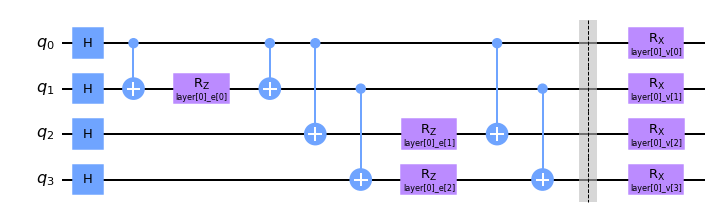

In [4]:
n_qubits = 4
reps = 1
edges = [(0, 1), (0, 2), (1, 3)] # Hardcoded edges for testing.
n_edges = len(edges)

data_symbols = []
for layer in range(reps):
    data = [Parameter(f'layer[{layer}]_v[{qubit}]') for qubit in range(n_qubits)]
    data += [[Parameter(f'layer[{layer}]_e[{ew}]') for ew in range(n_edges)]]
    data_symbols.append(data)

qc = graph_encoding_circuit(edges, n_qubits, reps, data_symbols)
qc.draw("mpl", fold=50)

## Classical Layers

### Equivariant Layer

Not to be confused with the Equivariant Parametrized Quantum Circuit!

In [5]:
class EquivariantLayer(torch.nn.Module):
    def __init__(
            self,
            num_input_params : int,
            n_vars : int,
            n_edges : int,
            circuit_depth : int,
            params : list):
        super(EquivariantLayer, self).__init__()

        # Define weights for the Layer
        self.num_input_params = num_input_params * circuit_depth
        self.num_params = 2 * circuit_depth
        self.circuit_depth = circuit_depth

        param_init = torch.ones(1, self.num_params, dtype=torch.float32)
        self.params = torch.nn.Parameter(param_init)

        self.param_repeats = []
        for layer in range(self.circuit_depth):
            self.param_repeats.append(n_vars)
            self.param_repeats.append(n_edges)

        alphabetical_params = sorted(params)
        self.indices = [params.index(a) for a in alphabetical_params]

    def forward(self, inputs):
        repeated_params = self.params.repeat_interleave(torch.tensor(self.param_repeats))

        repeat_inputs = inputs.repeat(self.circuit_depth, 1)

        data_values = repeat_inputs * repeated_params
        output = data_values[:, self.indices]

        return output

### Post-processing layer

In [6]:
class TrainableRescaling(torch.nn.Module):
    def __init__(self, input_dim : int):
        super(TrainableRescaling, self).__init__()

        """
        In PyTorch does not have an argument controlling whether a Parameter is trainable or
        not. If you want to freeze the parameter (making it non-trainable), you will need
        to manually set requires_grad to False after the parameter is initialized.
        """
        self.w = torch.nn.Parameter(torch.ones(1, input_dim), requires_grad=True)

    def forward(self, inputs):
        return inputs * self.w.repeat(inputs.shape[0], 1)

## Utils

In [7]:
def graph_to_list(nodes : list, fully_connected_edges : list[tuple], edge_weights : dict,
                  available_nodes : list[int], node_to_qubit_map : dict) -> list[float]:
    vals = []
    for node in nodes:
        vals.append(int(node_to_qubit_map[node] in available_nodes) * np.pi)

    for edge in fully_connected_edges:
        vals.append(np.arctan(edge_weights[edge]))

    return vals

def compute_tour_length(nodes : list[tuple], tour : list[int]) -> float:
    """
    Compute length of a tour, including return to start node.
    (If start node is already added as last node in tour, 0 will be added to tour length.)
    :param nodes: all nodes in the graph in form of (x, y) coordinates
    :param tour: list of node indices denoting a (potentially partial) tour
    :return: tour length
    """
    tour_length = 0
    for i in range(len(tour)):
        if i < len(tour)-1:
            tour_length += np.linalg.norm(np.asarray(nodes[tour[i]]) - np.asarray(nodes[tour[i+1]]))
        else:
            tour_length += np.linalg.norm(np.asarray(nodes[tour[-1]]) - np.asarray(nodes[tour[0]]))

    return tour_length

def cost(nodes : list[tuple], tour : list[int]) -> float:
    return -compute_tour_length(nodes, tour)

def compute_reward(nodes : list[tuple], old_state : list[int], state : list[int]):
    return cost(nodes, state) - cost(nodes, old_state)

def get_masks_for_actions(edge_weights, partial_tours):
    batch_masks = []
    for tour_ix, partial_tour in enumerate(partial_tours):
        mask = []
        for edge, weight in edge_weights[tour_ix].items():
            if edge in partial_tour or (edge[1], edge[0]) in partial_tour:
                mask.append(weight)
            else:
                mask.append(0)

        batch_masks.append(mask)

    return np.asarray(batch_masks)

## Q-Learning model

In [8]:
from collections import deque

class QLearning:
    def __init__(self, hyperparams : dict, path : str = BASE_PATH):
        self.path = path

        self.n_vars = hyperparams.get('n_vars')
        self.episodes = hyperparams.get('episodes')
        self.batch_size = hyperparams.get('batch_size')
        self.gamma = hyperparams.get('gamma')
        self.n_layers = hyperparams.get('n_layers')
        self.update_after = hyperparams.get('update_after')
        self.update_target_after = hyperparams.get('update_target_after')
        self.memory_length = hyperparams.get('memory_length')
        self.n_pred_layers = hyperparams.get('n_pred_layers', 1)

        self.epsilon = hyperparams.get('epsilon')
        self.epsilon_schedule = hyperparams.get('epsilon_schedule')
        self.epsilon_min = hyperparams.get('epsilon_min')
        self.epsilon_decay = hyperparams.get('epsilon_decay')

        self.learning_rate = hyperparams.get('learning_rate', 0.01)
        self.learning_rate_out = hyperparams.get('learning_rate_out', 0.01)
        self.learning_rate_in = hyperparams.get('learning_rate_in', 0.01)

        # We should add parameters to Adam
        # self.optimizer = Adam({}, lr=self.learning_rate, amsgrad=True)
        # self.optimizer_output = Adam({}, lr=self.learning_rate_out)
        # self.optimizer_input = Adam({}, lr=self.learning_rate_in)

        self.optimizers = []
        self.w_idx = []

        self.loss_fun = MSELoss()

        self.memory = self.initialize_memory()

        self.meta = self.generate_meta_data_dict()

    def generate_meta_data_dict(self):
        meta = {key: str(value) for key, value in self.__dict__.items() if
                not key.startswith('__') and not callable(key)}

        # del meta['optimizer']
        # del meta['optimizer_output']
        del meta['loss_fun']
        del meta['memory']

        return meta

    def initialize_memory(self):
        memory = deque(maxlen=self.memory_length)
        return memory

    def add_to_memory(self, state, action, reward, next_state, done):
        transition = self.interaction(
            state, action, reward, next_state, float(done))
        self.memory.append(transition)

In [10]:
from itertools import combinations
from collections import namedtuple

import pickle
import copy

class QModel(Module):
    def __init__(self, n_input_params : int, n_vars : int, num_edges_in_graph : int, n_layers : int,
                 flattened_data_symbols : list, circuit : QuantumCircuit):
        super(QModel, self).__init__()

        self.encoding_layer = EquivariantLayer(num_input_params=n_input_params, n_vars=n_vars, n_edges=num_edges_in_graph,
                                               circuit_depth=n_layers, params=flattened_data_symbols)

        self.circuit = circuit
        #self.output_extension_layer = Sequential(
        #    TrainableRescaling(n_readout_op)
        #)

    def forward(self, input_data, observables):
        encoding_output = self.encoding_layer(input_data)

        qnn = EstimatorQNN(
            circuit=self.circuit,
            input_params=self.circuit.parameters,
            observables=observables
        )
        qnn = TorchConnector(qnn)
        expectation_values = qnn(encoding_output)

        # output = self.output_extension_layer(expectation_values)
        return expectation_values

class QLearningTsp(QLearning):
    def __init__(self,
                 hyperparams : dict,
                 path :str =BASE_PATH):

        super(QLearningTsp, self).__init__(hyperparams, path)

        self.fully_connected_qubits = list(combinations(list(range(self.n_vars)), 2))
        self.is_multi_instance = hyperparams.get('is_multi_instance')
        self.interaction = namedtuple(typename='interaction', field_names=('state', 'action', 'reward', 'next_state', 'done', 'partial_tour', 'edge_weights'))
        self.model = self.generate_eqc_model()

        self.optimizer = Adam(self.model.parameters(), lr=self.learning_rate_in)

        self.data_path = hyperparams.get('data_path')

    def generate_eqc_model(self):
        num_edges_in_graph = len(self.fully_connected_qubits)
        n_input_params = self.n_vars + num_edges_in_graph

        data_symbols = []
        for layer in range(self.n_layers):
            data = [Parameter(f'layer[{layer}]_v[{qubit}]') for qubit in range(self.n_vars)]
            data += [[Parameter(f'layer[{layer}]_e[{ew}]') for ew in range(num_edges_in_graph)]]
            data_symbols.append(data)

        circuit = graph_encoding_circuit(self.fully_connected_qubits, self.n_vars, self.n_layers, data_symbols)

        flattened_data_symbols = []
        for layer in data_symbols:
            for item in layer:
                if type(item) == list:
                    for symbol in item:
                        flattened_data_symbols.append(str(symbol))
                else:
                    flattened_data_symbols.append(str(item))

        model = QModel(n_input_params=n_input_params, n_vars=self.n_vars, num_edges_in_graph=num_edges_in_graph, n_layers=self.n_layers,
                       flattened_data_symbols=flattened_data_symbols, circuit=circuit)

        return model

    def q_vals_from_expectation(self, partial_tours : list,
                                edge_weights : list, expectations) -> ndarray:
        expectations = expectations.detach().numpy()
        indexed_expectations = []
        for exps in expectations:
            batch_ix_exp = {}
            for edge, exp_val in zip(self.fully_connected_qubits, exps):
                batch_ix_exp[edge] = exp_val
            indexed_expectations.append(batch_ix_exp)

        batch_q_vals = []
        for tour_ix, partial_tour in enumerate(partial_tours):
            q_vals = []
            for i in range(self.n_vars):
                node_in_tour = False
                for edge in partial_tour:
                    if i in edge:
                        node_in_tour = True

                if not node_in_tour:
                    next_edge = None
                    if partial_tour:
                        next_edge = (partial_tour[-1][1], i)
                    else:
                        if i > 0:
                            next_edge = (0, i)

                    if next_edge is not None:
                        try:
                            q_val = edge_weights[tour_ix][next_edge] * indexed_expectations[tour_ix][next_edge]
                        except KeyError:
                            q_val = edge_weights[tour_ix][
                                (next_edge[1], next_edge[0])] * indexed_expectations[tour_ix][
                                        (next_edge[1], next_edge[0])]
                    else:
                        q_val = -10000
                else:
                    q_val = -10000
                q_vals.append(q_val)

            batch_q_vals.append(q_vals)

        return np.asarray(batch_q_vals)

    def get_observables(self, edge_weights: dict | list[dict], partial_tours:  list[int] | list[list[int]]) -> tuple[list[SparsePauliOp], list[int]] | list[tuple[list[SparsePauliOp], list[int]]]:
        if not isinstance(edge_weights, list):
            edge_weights = [edge_weights]

        if not isinstance(partial_tours[0], list):
            partial_tours = [partial_tours]

        observables_batch = []
        available_nodes_batch = []

        for i, partial_tour in enumerate(partial_tours):
            observables = []
            available_nodes = []
            last_edge = partial_tour[-1]
            last_node = last_edge[1]

            edge_weight_batch = edge_weights[i] if isinstance(edge_weights[i], list) else [edge_weights[i]]

            for edge_weight in edge_weight_batch:
                for edge, weight in edge_weight.items():
                    if edge[0] == last_node or edge[1] == last_node:
                        if edge[0] == last_node and len([tup for tup in partial_tour if tup[0] == edge[1]]) >= 1:
                            continue
                        elif edge[1] == last_node and len([tup for tup in partial_tour if tup[0] == edge[0]]) >= 1:
                            continue

                        if edge[0] == last_node:
                            available_nodes.append(edge[1])
                        else:
                            available_nodes.append(edge[0])

                        observable = SparsePauliOp.from_sparse_list(
                            [("ZZ", [edge[0], edge[1]], weight)],
                            num_qubits=self.n_vars
                        )
                        observables.append(observable)

            if observables == []:
                observable = SparsePauliOp.from_sparse_list(
                    [("I", [0], 0)],
                    num_qubits=self.n_vars
                )
                observables.append(observable)
                available_nodes.append(0)

            observables_batch.append(observables)
            available_nodes_batch.append(available_nodes)

        if len(partial_tours) == 1:
            return observables_batch[0], available_nodes_batch[0]
        else:
            return observables_batch, available_nodes_batch

    def get_action(self, state_list : list[float], available_nodes : list,
                   partial_tour : list[int], edge_weights : dict):

        if np.random.uniform() < self.epsilon:
            action = random.choice(available_nodes)
        else:
            state_tensor = torch.tensor(state_list).unsqueeze(0)

            observables, available_nodes = self.get_observables(
                edge_weights=edge_weights,
                partial_tours=partial_tour
            )
            expectations = self.model(state_tensor, observables)

            # q_vals = self.q_vals_from_expectation([partial_tour], [edge_weights], expectations)[0]
            action = available_nodes[torch.argmax(torch.tensor(expectations)).item()]

        return action

    def train_step(self):
        training_batch = random.choices(self.memory, k=self.batch_size)
        training_batch = self.interaction(*zip(*training_batch))

        states = [x for x in training_batch.state]
        rewards = np.asarray([x for x in training_batch.reward], dtype=np.float32)
        next_states = [x for x in training_batch.next_state]
        done = np.asarray([x for x in training_batch.done])
        partial_tours = [x for x in training_batch.partial_tour]
        edge_weights = [x for x in training_batch.edge_weights]

        states = torch.tensor(states)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states)
        done = torch.tensor(done, dtype=torch.float64)

        observables_batched, available_nodes_batched = self.get_observables(
            edge_weights=edge_weights,
            partial_tours=partial_tours
        )

        exp_values_future = []
        for i, observables in enumerate(observables_batched):
            exp_values_future.append(self.model(next_states[i], observables))
        
        # TODO: Use available_nodes to get the future_rewards.
        future_rewards = []
        for exp_values in exp_values_future:
            future_rewards.append(torch.max(torch.tensor(exp_values)))

        #future_rewards = torch.tensor(self.q_vals_from_expectation(
        #    partial_tours, edge_weights, exp_values_future), dtype=torch.float64)

        target_q_values = rewards + (self.gamma * torch.stack(future_rewards) * (1.0 - done))

        self.model.zero_grad()

        # TODO: Precalculate the observables and use them with masks.
        exp_values = self.model(states)
        exp_val_masks = get_masks_for_actions(edge_weights, partial_tours)
        q_values_masked = torch.sum(exp_values.detach() * exp_val_masks, dim=1)
        loss = self.loss_fun(target_q_values, q_values_masked)

        # Backward pass
        # loss.backward()

        grads = [param.grad for param in self.model.parameters()]

        if len(self.optimizers) == 1:
            # Compute the gradients
            loss.backward()

            # Update the weights
            self.optimizers[0].step()
        else:
            for optimizer, w in zip(self.optimizers, self.w_idx):
                optimizer.zero_grad() # Clear the gradient buffer
                loss.backward() # Compute gradients for each variable

                # Manually set gradients for specific parameters and update weights
                for ind, param in enumerate(self.model.parameters()):
                    if ind == w:
                        param.grad = grads[w] # grads[w] is assumed to be already known
                optimizer.step()

        # After updating weights, you may want to set the gradients to zero for the next iteration
        for optimizer in self.optimizers:
            optimizer.zero_grad()

        return loss.numpy()

    def perform_episodes(self, num_instances : int) -> None:
        self.meta['num_instances'] = num_instances
        self.meta['best_tour_length'] = 100000
        self.meta['best_tour'] = []
        self.meta['best_tour_ix'] = 0
        self.meta['env_solved'] = False

        with open(self.data_path, 'rb') as file:
            data = pickle.load(file)

        if self.is_multi_instance:
            x_train = data['x_train'][:num_instances]
            y_train = data['y_train'][:num_instances]
        else:
            x_train = data['x_train']
            y_train = data['y_train']

        tour_length_history = []
        optimal_tour_length_history = []
        ratio_history = []
        running_avgs = []
        running_avg = 0

        for episode in range(self.episodes):
            instance_number = random.randint(0, num_instances - 1)
            tsp_graph_nodes = x_train[instance_number]
            optimal_tour_length = compute_tour_length(
                tsp_graph_nodes, [int(x - 1) for x in y_train[instance_number][:-1]])
            node_to_qubit_map = {}
            for i, node in enumerate(tsp_graph_nodes):
                node_to_qubit_map[node] = i

            fully_connected_edges = []
            edge_weights = {}
            edge_weights_ix = {}
            for edge in self.fully_connected_qubits:
                fully_connected_edges.append((tsp_graph_nodes[edge[0]], tsp_graph_nodes[edge[1]]))
                edge_distance = np.linalg.norm(
                    np.asarray(tsp_graph_nodes[edge[0]]) - np.asarray(tsp_graph_nodes[edge[1]]))
                edge_weights[(tsp_graph_nodes[edge[0]], tsp_graph_nodes[edge[1]])] = edge_distance
                edge_weights_ix[edge] = edge_distance

            tour = [0]  # Without loss of generality we always start at city 0
            tour_edges = []
            step_rewards = []
            available_nodes = list(range(1, self.n_vars))

            for i in range(self.n_vars):
                prev_tour = copy.deepcopy(tour)
                state_list = graph_to_list(
                    tsp_graph_nodes, fully_connected_edges, edge_weights,
                    available_nodes, node_to_qubit_map)

                next_node = self.get_action(state_list, available_nodes, tour_edges, edge_weights_ix)
                tour_edges.append((tour[-1], next_node))
                new_tour_edges = copy.deepcopy(tour_edges)
                tour.append(next_node)

                remove_node_ix = available_nodes.index(next_node)
                del available_nodes[remove_node_ix]

                if len(tour) > 1:
                    reward = compute_reward(tsp_graph_nodes, prev_tour, tour)
                    step_rewards.append(reward)

                    done = 0 if len(available_nodes) > 1 else 1
                    transition = (state_list, next_node, reward, graph_to_list(
                        tsp_graph_nodes, fully_connected_edges, edge_weights,
                        available_nodes, node_to_qubit_map), done, new_tour_edges, edge_weights_ix)
                    self.memory.append(transition)

                if len(available_nodes) == 1:
                    prev_tour = copy.deepcopy(tour)

                    tour_edges.append((tour[-1], available_nodes[0]))
                    tour_edges.append((available_nodes[0], tour[0]))
                    new_tour_edges = copy.deepcopy(tour_edges)

                    tour.append(available_nodes[0])
                    tour.append(tour[0])

                    reward = compute_reward(tsp_graph_nodes, prev_tour, tour)
                    step_rewards.append(reward)

                    transition = (state_list, next_node, reward, graph_to_list(
                        tsp_graph_nodes, fully_connected_edges, edge_weights,
                        available_nodes, node_to_qubit_map), 1, new_tour_edges, edge_weights_ix)
                    self.memory.append(transition)
                    break

            tour_length = compute_tour_length(tsp_graph_nodes, tour)
            tour_length_history.append(tour_length)
            optimal_tour_length_history.append(optimal_tour_length)

            if tour_length < self.meta.get('best_tour_length'):
                self.meta['best_tour_length'] = tour_length
                self.meta['best_tour'] = tour
                self.meta['best_tour_ix'] = instance_number

            if len(self.memory) >= self.batch_size:
                if episode % self.update_after == 0:
                    loss = self.train_step()
                    print(
                        f"Episode {episode}, loss {loss}, running avg {running_avg}, epsilon {self.epsilon}")
                    print(f"\tFinal tour: {tour}")
                else:
                    print(
                            f"Episode {episode}, running avg {running_avg}, epsilon {self.epsilon}")
                    print(f"\tFinal tour: {tour}")

                # TODO: Set weights for the target model.
                # if episode % self.update_target_after == 0:
                    # self.target_model.set_weights(self.model.get_weights())

            if self.epsilon_schedule == 'fast':
                self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

            ratio_history.append(tour_length_history[-1] / optimal_tour_length)

            if len(ratio_history) >= 100:
                running_avg = np.mean(ratio_history[-100:])
            else:
                running_avg = np.mean(ratio_history)

            running_avgs.append(running_avg)

            if len(ratio_history) >= 100 and running_avg <= 1.05:
                print(f"Environment solved in {episode+1} episodes!")
                self.meta['env_solved'] = True
                break

        # This is just for visualization purposes.
        plt.plot(running_avgs)
        plt.ylabel("Ratio to optimal tour length")
        plt.xlabel("Episode")
        plt.title("Running average over past 100 episodes")
        plt.show()


for i in range(hyperparams.get('repetitions', 1)):
    tsp_multi = QLearningTsp(
        hyperparams=hyperparams,
        path='/save_path/',
    )

    tsp_multi.perform_episodes(
        num_instances=hyperparams.get('num_instances')
    )

Episode 1, running avg 1.9279332404327274, epsilon 0.99
	Final tour: [0, 5, 1, 4, 9, 6, 7, 2, 8, 3, 0]
Episode 2, running avg 1.7757560024189947, epsilon 0.9801
	Final tour: [0, 8, 4, 1, 9, 2, 7, 5, 6, 3, 0]
Episode 3, running avg 1.9010572419858143, epsilon 0.9702989999999999
	Final tour: [0, 1, 3, 6, 9, 7, 8, 4, 2, 5, 0]
Episode 4, running avg 1.8370166120482343, epsilon 0.96059601
	Final tour: [0, 6, 4, 8, 3, 9, 7, 1, 5, 2, 0]
Episode 5, running avg 1.8199479439976827, epsilon 0.9509900498999999
	Final tour: [0, 3, 8, 1, 6, 5, 4, 9, 7, 2, 0]


C:\Users\yeray142\AppData\Local\Temp\ipykernel_16280\4210566223.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = available_nodes[torch.argmax(torch.tensor(expectations)).item()]


Episode 6, running avg 1.8147890181245245, epsilon 0.9414801494009999
	Final tour: [0, 8, 1, 5, 3, 2, 6, 7, 9, 4, 0]
Episode 7, running avg 1.825171551030351, epsilon 0.9320653479069899
	Final tour: [0, 1, 5, 7, 8, 2, 3, 9, 6, 4, 0]
Episode 8, running avg 1.8863197293300762, epsilon 0.92274469442792
	Final tour: [0, 3, 6, 9, 8, 5, 1, 2, 7, 4, 0]
Episode 9, running avg 1.8647951350676246, epsilon 0.9135172474836407
	Final tour: [0, 9, 8, 2, 5, 3, 7, 1, 6, 4, 0]


C:\Users\yeray142\AppData\Local\Temp\ipykernel_16280\4210566223.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  future_rewards.append(torch.max(torch.tensor(exp_values)))


TypeError: QModel.forward() missing 1 required positional argument: 'observables'